# Direct comparison to Sospedra-Alfonso et al. (2021) analysis of CanESM5

This note book presents comparions to results in the Sospedra-Alfonso et al. (2021) CanESM5 paper.

Unfortunately, Sospedra-Alfonso et al. (2021) don't provide all the details required to recreate their plots (climatological period, verification period). It's also not near to me how "year 1" of their forecast is defined, but I think it's equivalent to my "year 0". Let's see if we can get something close to their results using our code. Note, Sospedra-Alfonso et al. (2021) compare to different reanalysis datasets than we do, so we can never expect to match exactly.

In [1]:
import warnings

warnings.filterwarnings("ignore")

import xarray as xr

import xskillscore as xs

import matplotlib as mpl
import matplotlib.pyplot as plt

import sys

sys.path.append("..")

from notebook_helper import plot_metrics, plot_metric_maps, plot_hindcasts

In [2]:
mpl.rcParams["figure.figsize"] = (15, 5.5)

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

## Compare SST metrics

In the CanESM5 paper, they compare to ERSST v5, whereas we compare to HadISST. It's also very like that the climatological period used for anomalisation is different between us and them. Here we use 1984-2014, I have no idea what they use.

### Correlation metrics

![sst_corr](./figures/sst_corr.png)

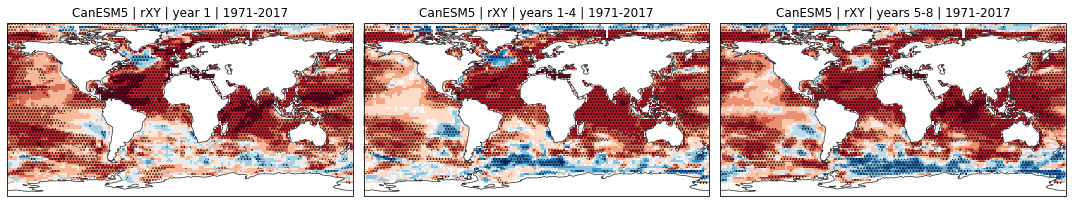

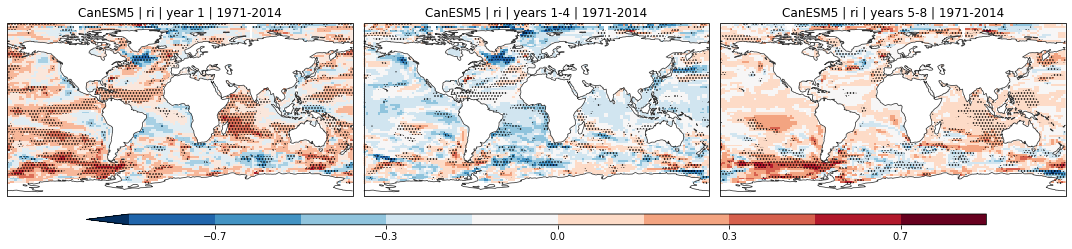

In [4]:
_ = plot_metric_maps(
    ["CanESM5"],
    "HadISST",
    "sst",
    "rXY",
    verif_period="1971-2017",
    add_colorbar=False,
    cbar_bounds=[-0.9, -0.7, -0.5, -0.3, -0.1, 0, 0.1, 0.3, 0.5, 0.7, 0.9],
    cmap="RdBu_r",
    central_longitude=0,
)

_ = plot_metric_maps(
    ["CanESM5"],
    "HadISST",
    "sst",
    "ri",
    verif_period="1971-2017",
    cbar_bounds=[-0.9, -0.7, -0.5, -0.3, -0.1, 0, 0.1, 0.3, 0.5, 0.7, 0.9],
    cmap="RdBu_r",
    central_longitude=0,
)

### MSSS metrics

![sst_msss](./figures/sst_msss.png)

In [ ]:
_ = plot_metric_maps(
    ["CanESM5"],
    "HadISST",
    "sst",
    "MSSS_clim",
    verif_period="1971-2017",
    add_colorbar=False,
    cbar_bounds=[-5, -3, -2, -1.5, -1, -0.5, -0.1, 0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
    cmap="RdBu_r",
    central_longitude=0,
)

_ = plot_metric_maps(
    ["CanESM5"],
    "HadISST",
    "sst",
    "MSSS_pers",
    verif_period="1971-2017",
    add_colorbar=False,
    cbar_bounds=[-5, -3, -2, -1.5, -1, -0.5, -0.1, 0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
    cmap="RdBu_r",
    central_longitude=0,
)

_ = plot_metric_maps(
    ["CanESM5"],
    "HadISST",
    "sst",
    "MSSS_hist",
    verif_period="1971-2014",
    cbar_bounds=[-5, -3, -2, -1.5, -1, -0.5, -0.1, 0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
    cmap="RdBu_r",
    central_longitude=0,
)

## Why do the persistence skills not match?
Our persistence skill is quite a lot higher than that reported in Sospedra-Alfonso et al. (2021). Who's correct?

In [ ]:
from distributed import Client
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 48
memory = "192GB"
cluster = PBSCluster(
    processes=1,
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-q express",
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83+gdata/oi10+gdata/ua8",
    ],
    local_directory="$PBS_JOBFS",
    header_skip=["select"],
)

cluster.scale(jobs=1)
client = Client(cluster)
print(f"Dask daskboard link: {client.dashboard_link}")

In [ ]:
hindcast = xr.open_zarr(
    "../data/processed/CanESM5.annual.anom_1985-2014.sst_global.zarr"
)

observation = xr.open_zarr(
    "../data/processed/HadISST.annual.anom_1985-2014.sst_global.zarr"
)
observation = observation.where(observation.time.dt.month == 12, drop=True)

### Let's manually compute the persistence skill

In [ ]:
lead = 1
period = ["1971-01-01", "2017-12-31"]

In [ ]:
persistence_shift = lead + 1  # timestep before lead 0

hindcast_at_lead = (
    hindcast.isel(lead=lead)
    .swap_dims({"init": "time"})
    .sel(time=slice(period[0], period[1]))
)
persistence_forecast = observation.shift(time=persistence_shift).sel(
    time=hindcast_at_lead.time
)
observation_at_lead = observation.sel(time=hindcast_at_lead.time)

Does this look right?

In [ ]:
def global_mean(ds, area="area", lon_dim="lon", lat_dim="lat"):
    return ds.weighted(ds[area].fillna(0)).mean([lon_dim, lat_dim])

In [ ]:
hindcast_gbl = global_mean(hindcast_at_lead.mean("member"))["sst"].compute()
persistence_gbl = global_mean(persistence_forecast)["sst"].compute()
observation_gbl = global_mean(observation_at_lead)["sst"].compute()

In [ ]:
hindcast_gbl.plot(color="C1", label="hindcast")
persistence_gbl.plot(color="k", linestyle="--", label="persistence")
observation_gbl.plot(color="k", linestyle="-", label="observation")

plt.xticks(
    xr.cftime_range("1971-12-01", "2017-12-01", freq="12MS", calendar="julian").values,
    rotation=90,
)
plt.grid()
plt.legend()

For lead year 1, persistence knows about what happened two years prior. That's correct. Let's manually compute the MSSS for this.

In [ ]:
num = xs.mse(
    hindcast_at_lead.mean("member"), observation_at_lead, dim="time", skipna=True
)
den = xs.mse(persistence_forecast, observation_at_lead, dim="time", skipna=True)
MSSS = (1 - num / den).compute()

In [ ]:
from src import plot

_ = plot.metric_maps(
    [[MSSS]],
    variable="sst",
    vrange=(-5, 1),
    headings=[["CanESM5 | MSSS_pers (manual) | year 1"]],
    cbar_bounds=[-5, -3, -2, -1.5, -1, -0.5, -0.1, 0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
    cmap="RdBu_r",
    central_longitude=0,
    figsize=(5, 3),
)

This is the same as my results above

### Are the CanESM5 results out by one year?

In [ ]:
persistence_shift = lead  # Use lead 0 as persistence forecast

hindcast_at_lead = (
    hindcast.isel(lead=lead)
    .swap_dims({"init": "time"})
    .sel(time=slice(period[0], period[1]))
)
persistence_forecast = observation.shift(time=persistence_shift).sel(
    time=hindcast_at_lead.time
)
observation_at_lead = observation.sel(time=hindcast_at_lead.time)

In [ ]:
num = xs.mse(
    hindcast_at_lead.mean("member"), observation_at_lead, dim="time", skipna=True
)
den = xs.mse(persistence_forecast, observation_at_lead, dim="time", skipna=True)
MSSS = (1 - num / den).compute()

In [ ]:
from src import plot

_ = plot.metric_maps(
    [[MSSS]],
    variable="sst",
    vrange=(-5, 1),
    headings=[["CanESM5 | MSSS_pers (manual) | year 1"]],
    cbar_bounds=[-5, -3, -2, -1.5, -1, -0.5, -0.1, 0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
    cmap="RdBu_r",
    central_longitude=0,
    figsize=(5, 3),
)

Hmmm, that's a lot closer to the Sospedra-Alfonso et al. (2021) results so maybe...

### For complete peace of mind let's manually recreate our data preparation steps and check timeseries are correct

In [ ]:
def estimate_cell_areas(ds, lon_dim="lon", lat_dim="lat"):
    """
    Calculate the area of each grid cell.
    Stolen/adapted from: https://towardsdatascience.com/the-correct-way-to-average-the-globe-92ceecd172b7
    """

    from numpy import deg2rad, cos, tan, arctan

    def _earth_radius(lat):
        """Calculate radius of Earth assuming oblate spheroid defined by WGS84"""

        # define oblate spheroid from WGS84
        a = 6378137
        b = 6356752.3142
        e2 = 1 - (b**2 / a**2)

        # convert from geodecic to geocentric
        # see equation 3-110 in WGS84
        lat = deg2rad(lat)
        lat_gc = arctan((1 - e2) * tan(lat))

        # radius equation
        # see equation 3-107 in WGS84
        return (a * (1 - e2) ** 0.5) / (1 - (e2 * cos(lat_gc) ** 2)) ** 0.5

    R = _earth_radius(ds[lat_dim])

    dlat = deg2rad(ds[lat_dim].diff(lat_dim))
    dlon = deg2rad(ds[lon_dim].diff(lon_dim))

    dy = dlat * R
    dx = dlon * R * cos(deg2rad(ds[lat_dim]))

    return (dy * dx).broadcast_like(ds[[lon_dim, lat_dim]]).fillna(0)

In [ ]:
from src import prepare_data, utils

In [ ]:
hindcast_raw = prepare_data._open.CanESM5(["tos"], "Omon", None)
hindcast_manual = hindcast_raw.coarsen(lead=12).mean()

In [ ]:
observation_raw = utils.round_to_start_of_month(
    prepare_data._open.HadISST(["sst"], None, None), dim="time"
)
observation_manual = observation_raw.coarsen(time=12, boundary="trim").mean()
observation_manual = utils.convert_calendar(observation_manual, "julian")
observation_manual = observation_manual.assign_coords(
    {
        "area": estimate_cell_areas(
            observation_manual, lon_dim="longitude", lat_dim="latitude"
        )
    }
)

In [ ]:
lead = 1

hindcast_at_lead = global_mean(
    hindcast_manual.isel(lead=lead)
    .swap_dims({"init": "time"})
    .sel(time=slice(period[0], period[1])),
    area="areacello",
    lon_dim="i",
    lat_dim="j",
).compute()

In [ ]:
observation_at_lead = global_mean(
    observation_manual.sel(time=hindcast_at_lead.time),
    area="area",
    lon_dim="longitude",
    lat_dim="latitude",
).compute()

In [ ]:
hindcast_anom = hindcast_at_lead - hindcast_at_lead.sel(
    time=slice("1985-01-01", "2014-12-31")
).mean("time")

observation_anom = observation_at_lead - observation_at_lead.sel(
    time=slice("1985-01-01", "2014-12-31")
).mean("time")

In [ ]:
hindcast_anom["tos"].mean("member").plot(color="C1", label="hindcast")
observation_anom["sst"].plot(color="k", linestyle="-", label="observation")

plt.xticks(
    xr.cftime_range("1971-12-01", "2017-12-01", freq="12MS", calendar="julian").values,
    rotation=90,
)
plt.grid()
plt.legend()